In [1]:
import anndata
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import platform
from optbinning import ContinuousOptimalBinning

import Main
import VisualUtils
import ClusterUtils
import TimeSeriesPreprocessor
import PathwayAnalyserV2

print(platform.python_version())

(CVXPY) Oct 11 05:41:15 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 11 05:41:15 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
3.9.16


Load the reference and query anndata objects

In [2]:
input_dir = 'data/'
adata_ref = anndata.read_h5ad(input_dir + 'adata_pam_local.h5ad') # PAM dataset
adata_query = anndata.read_h5ad(input_dir +'adata_lps_local.h5ad') # LPS dataset

In [3]:
print(adata_ref)
print(adata_query)

AnnData object with n_obs × n_vars = 179 × 89
    obs: 'time'
AnnData object with n_obs × n_vars = 290 × 89
    obs: 'time'


### Min max normalize the pseudotime

In [4]:
# check the current range
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

# if it does not follow [0,1] range, run below
adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

0.0 1.0
0.0 1.0


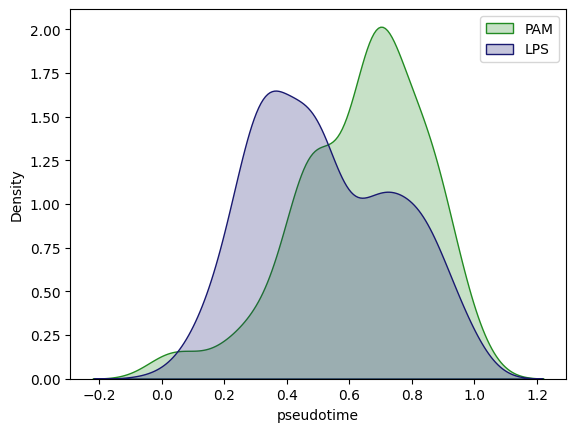

In [5]:
# Visualize the pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='PAM', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='LPS', color='midnightblue'); 
plt.xlabel('pseudotime'); plt.legend(); plt.show()

### Check the number of bins in the optimal binning structure using OptBinning package

In [6]:
x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

14
14


OptBinning estimates 14 optimal number of splits for both reference and query pseudotime distributions. Therefore we choose the same number of interpolation points.

### Visualize the interpolation binning structure in terms of the cell type composition 

For this dataset, we use the author-given time annotations (1h,2h,4h,6h) as the cell-type annotations. 

In [7]:
adata_ref.obs['annotation'] = [x.split('_')[1] for x in adata_ref.obs_names] 
adata_query.obs['annotation'] = [x.split('_')[1] for x in adata_query.obs_names] 

Next we define a colormap of our choice for these annotations, and call the below function. 

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


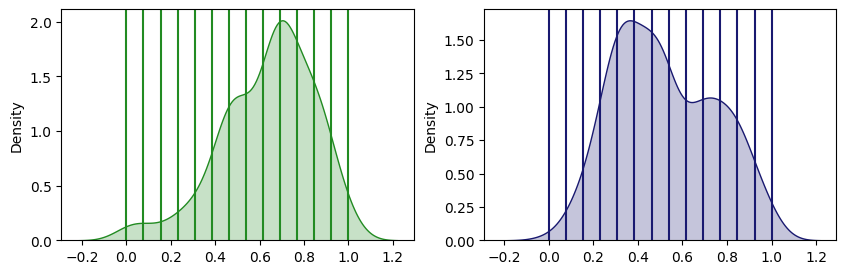

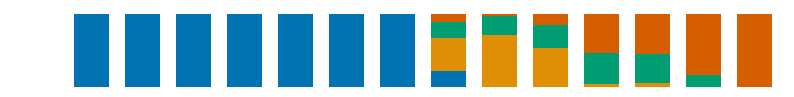

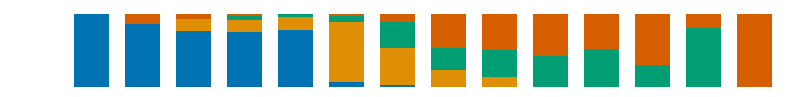

In [8]:
col = np.array(sb.color_palette('colorblind'))[range(4)]
joint_cmap={'1h':col[0], '2h':col[1] , '4h':col[2] , '6h':col[3]}
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, n_points=14, 
                                     ANNOTATION_COLNAME='annotation', optimal_binning=False, ref_cmap=joint_cmap, query_cmap=joint_cmap)

### Run G2G alignment

We can now run Gene-level alignment for all 89 genes in the PAM and LPS datasets

In [9]:
gene_list = adata_ref.var_names 
print(len(gene_list))

89


This is done by first creating an aligner object, passing and setting all relevant parameters.
Next we align all gene pairs. (This step is parallelizing indepedenent gene-alignments to make the process time-efficient, however the computational time for an individual alignment will increase as the number of cells and/or the number of interpolation time points increase. 

In [10]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE=0.1
aligner.state_params = [0.99,0.1,0.7]
aligner.optimal_binning = True
aligner.opt_binning_S = vs.optimal_bining_S
aligner.opt_binning_T = vs.optimal_bining_T
aligner.align_all_pairs() 

WINDOW_SIZE= 0.1


  0%|          | 0/89 [00:00<?, ?it/s]

Now we can check the aggregate (average) alignment across all genes:

Average Alignment:  IDDDMMMMMMMMMIIIDID


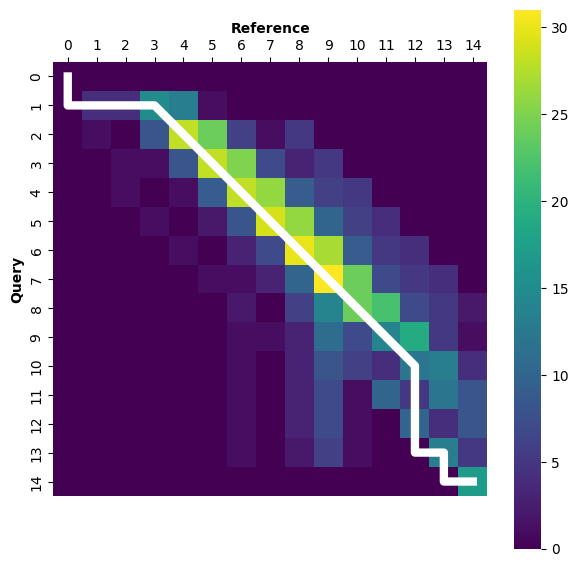

In [11]:
aligner.get_aggregate_alignment()

We can also visualize this alignment in terms of cell-type composition

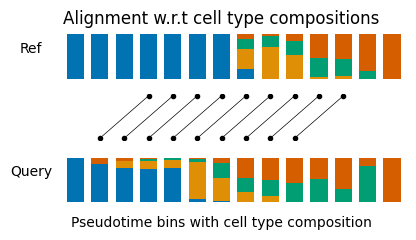

In [38]:
vs.visualize_gene_alignment("IDDDMMMMMMMMMIIIDID", cmap=joint_cmap)

We can also visualize an individual gene (e.g. JUNB), displaying its alignment statistics

DDDIDIDIDDDMMMMMIIIIIID
Optimal alignment cost: 57.99 nits
Alignment similarity percentage: 21.74 %


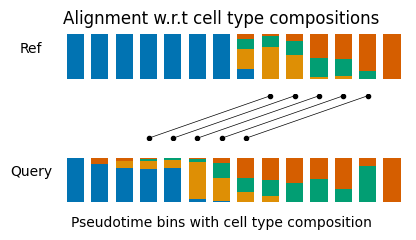

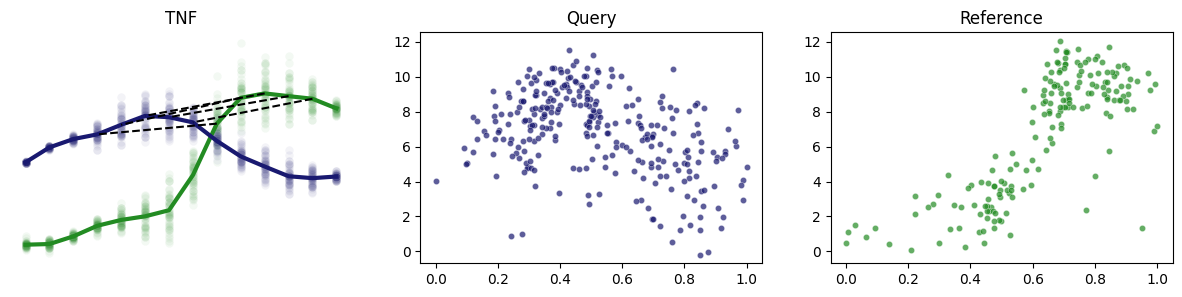

In [46]:
VisualUtils.show_gene_alignment('TNF', aligner, vs, joint_cmap)

To check only the cell plots of a gene alignment (e.g. SERTAD2)

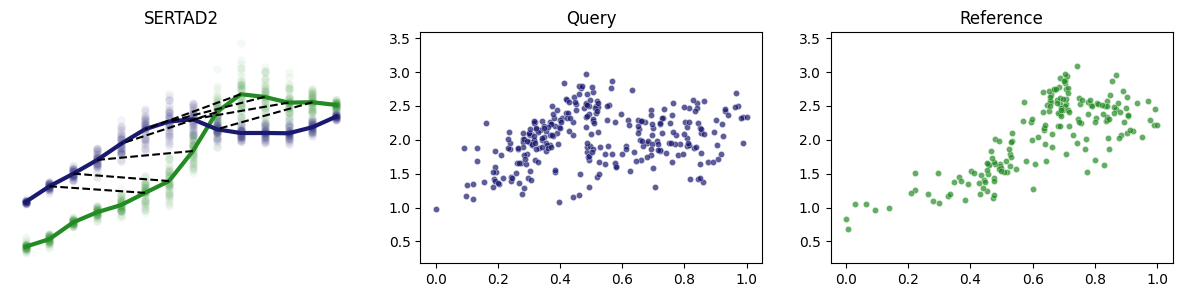

In [50]:
VisualUtils.plotTimeSeries('SERTAD2', aligner, plot_cells=True)

The below attributes and functions can be used to examine any gene-alignment object

In [80]:
GENE = 'TNF'
gene_obj = aligner.results_map[GENE]

al = gene_obj.alignment_str
print(al)
print(VisualUtils.color_al_str(al)) 

DDDIDIDIDDDMMMMMIIIIIID
DDDIDIDIDDDMMMMMIIIIIID


In [81]:
print(gene_obj.al_visual)

01234567890123456789012 Alignment index 
012 3 4 56789012      3 Reference index
***-*-*-********------*
---*-*-*---***********-
   0 1 2   34567890123  Query index
DDDIDIDIDDDMMMMMIIIIIID 5-state string 


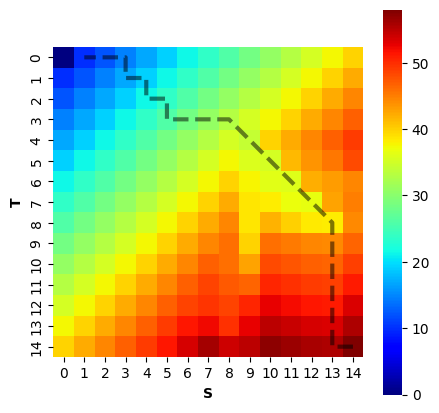

In [82]:
gene_obj.landscape_obj.plot_alignment_landscape()

### The alignment distribution across all genes 

We can use the alignment similarity percentage statistic of genes to rank genes from highly distant to highly similar

mean matched percentage: 
50.39 %


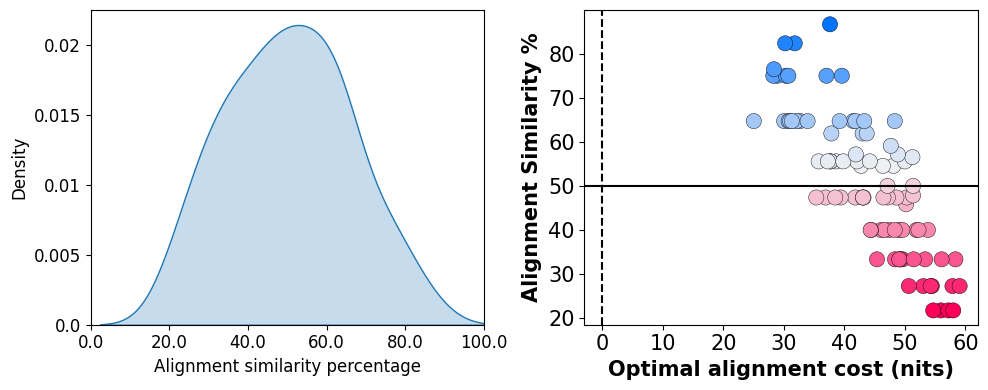

In [40]:
df = aligner.get_stat_df() 

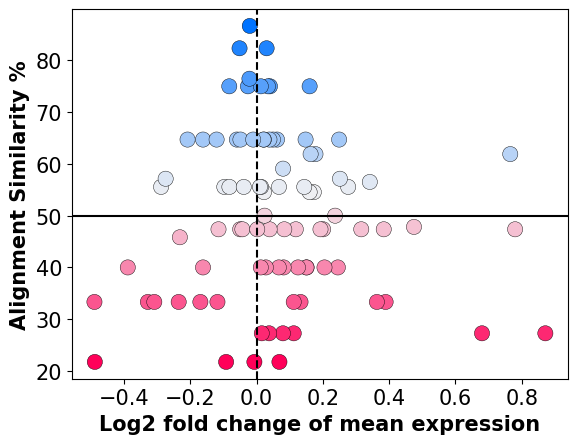

In [41]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)

In [51]:
df

,Gene,alignment_similarity_percentage,opt_alignment_cost,l2fc,color,abs_l2fc
63,CCRL2,0.2174,55.943685,-0.487688,red,0.487688
77,NFKBIA,0.2174,54.673471,-0.091748,red,0.091748
68,NLRP3,0.2174,57.177548,0.069058,red,0.069058
3,TNF,0.2174,57.990078,-0.006439,red,0.006439
45,C5AR1,0.2727,57.858236,0.8711,red,0.8711
...,...,...,...,...,...,...
34,NUP54,0.75,30.744063,0.012993,green,0.012993
15,CD44,0.7647,28.366715,-0.021366,green,0.021366
19,PLAGL2,0.8235,31.807956,-0.051268,green,0.051268
51,ZSWIM4,0.8235,30.214575,0.030379,green,0.030379


### Run gene set overrepresentation analysis over the top k mismatching genes

Let us use 30% alignment similarity (=0.3) as a threshold in this case

In [66]:
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.3)]['Gene']
topDEgenes

63      CCRL2
77     NFKBIA
68      NLRP3
3         TNF
45      C5AR1
84    SPATA13
33      CXCL2
12     RALGDS
31     INSIG1
6       MALT1
Name: Gene, dtype: object

In [69]:
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df[pathway_df['Adjusted P-value']<0.001] 

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
13,KEGG_2021_Human,C-type lectin receptor signaling pathway,4/104,1.414253e-07,0.000007,0,0,132.600000,2091.300110,NFKBIA;NLRP3;TNF;MALT1,5.182020,5.182020
14,KEGG_2021_Human,NF-kappa B signaling pathway,4/104,1.414253e-07,0.000007,0,0,132.600000,2091.300110,NFKBIA;TNF;CXCL2;MALT1,5.182020,5.182020
0,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,4/200,1.944057e-06,0.000013,0,0,67.326531,885.393278,NFKBIA;CCRL2;TNF;CXCL2,4.898378,4.898378
1,MSigDB_Hallmark_2020,Inflammatory Response,4/200,1.944057e-06,0.000013,0,0,67.326531,885.393278,NFKBIA;C5AR1;CCRL2;NLRP3,4.898378,4.898378
15,KEGG_2021_Human,NOD-like receptor signaling pathway,4/181,1.305897e-06,0.000040,0,0,74.625235,1011.068962,NFKBIA;NLRP3;TNF;CXCL2,4.392729,4.392729
16,KEGG_2021_Human,Lipid and atherosclerosis,4/215,2.592326e-06,0.000048,0,0,62.492891,803.843248,NFKBIA;NLRP3;TNF;CXCL2,4.316101,4.316101
17,KEGG_2021_Human,Legionellosis,3/57,2.596486e-06,0.000048,0,0,158.222222,2034.951617,NFKBIA;TNF;CXCL2,4.316101,4.316101
18,KEGG_2021_Human,Coronavirus disease,4/232,3.507534e-06,0.000054,0,0,57.783626,725.796849,NFKBIA;C5AR1;NLRP3;TNF,4.264666,4.264666
19,KEGG_2021_Human,Shigellosis,4/246,4.425543e-06,0.000059,0,0,54.402204,670.676767,NFKBIA;NLRP3;TNF;MALT1,4.230649,4.230649
20,KEGG_2021_Human,IL-17 signaling pathway,3/94,1.177987e-05,0.000137,0,0,93.715856,1063.592345,NFKBIA;TNF;CXCL2,3.863467,3.863467


### Clustering genes using their alignments

We first run cluster diagnostics to decide on a distance threshold with a good tradeoff between the number of clusters and the quality of structure. We use levenshtein distance metric

compute distance matrix
using levenshtein distance metric


 68%|██████▊   | 67/99 [00:00<00:00, 248.94it/s]


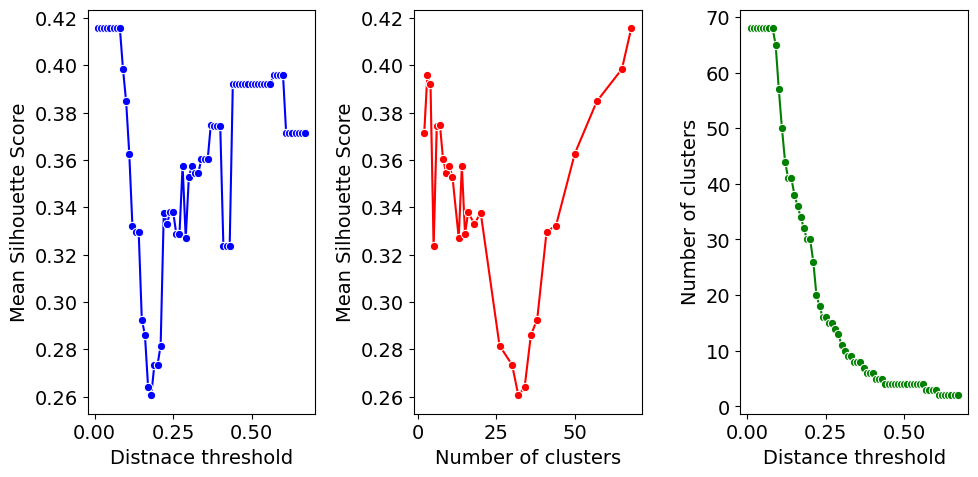

In [84]:
# Running experiment to determine the distance threshold with a good trade-off
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True) 

We can inspect structures of distance thresholds that give local optimals of the mean silhouette score.

In [86]:
df[df['Mean Silhouette Score'] > 0.37].sort_values('Distance threshold', ascending=False)

,Distance threshold,Mean Silhouette Score,Number of clusters
66,0.67,0.371279,2.0
65,0.66,0.371279,2.0
64,0.65,0.371279,2.0
63,0.64,0.371279,2.0
62,0.63,0.371279,2.0
61,0.62,0.371279,2.0
60,0.61,0.371279,2.0
59,0.60,0.395886,3.0
58,0.59,0.395886,3.0
57,0.58,0.395886,3.0


If we select distance threshold 0.37 which gives a local optimal of 0.3749 silhouette_score with 7 clusters

In [87]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.37) 

compute distance matrix
using levenshtein distance metric
run agglomerative clustering |  0.37
silhouette_score:  0.37494418907841714


Below visualizes all alignment paths in each cluster along with its number of genes 

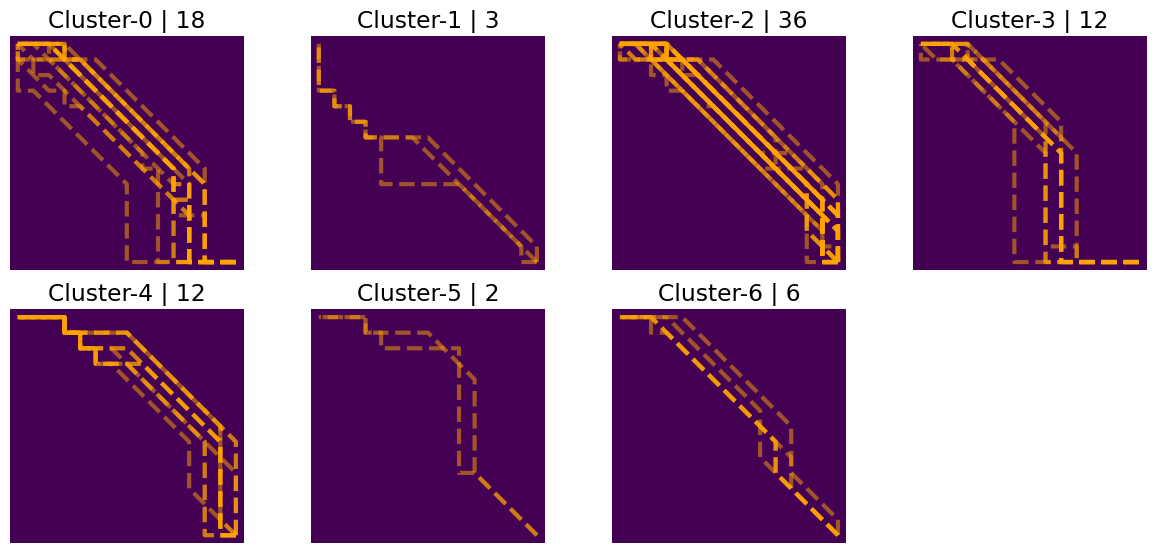

In [89]:
ClusterUtils.visualise_clusters(aligner,n_cols = 4, figsize= (10,6))

Below is the Levenshtein distance heat map of all genes ordered based on the above clustering structure

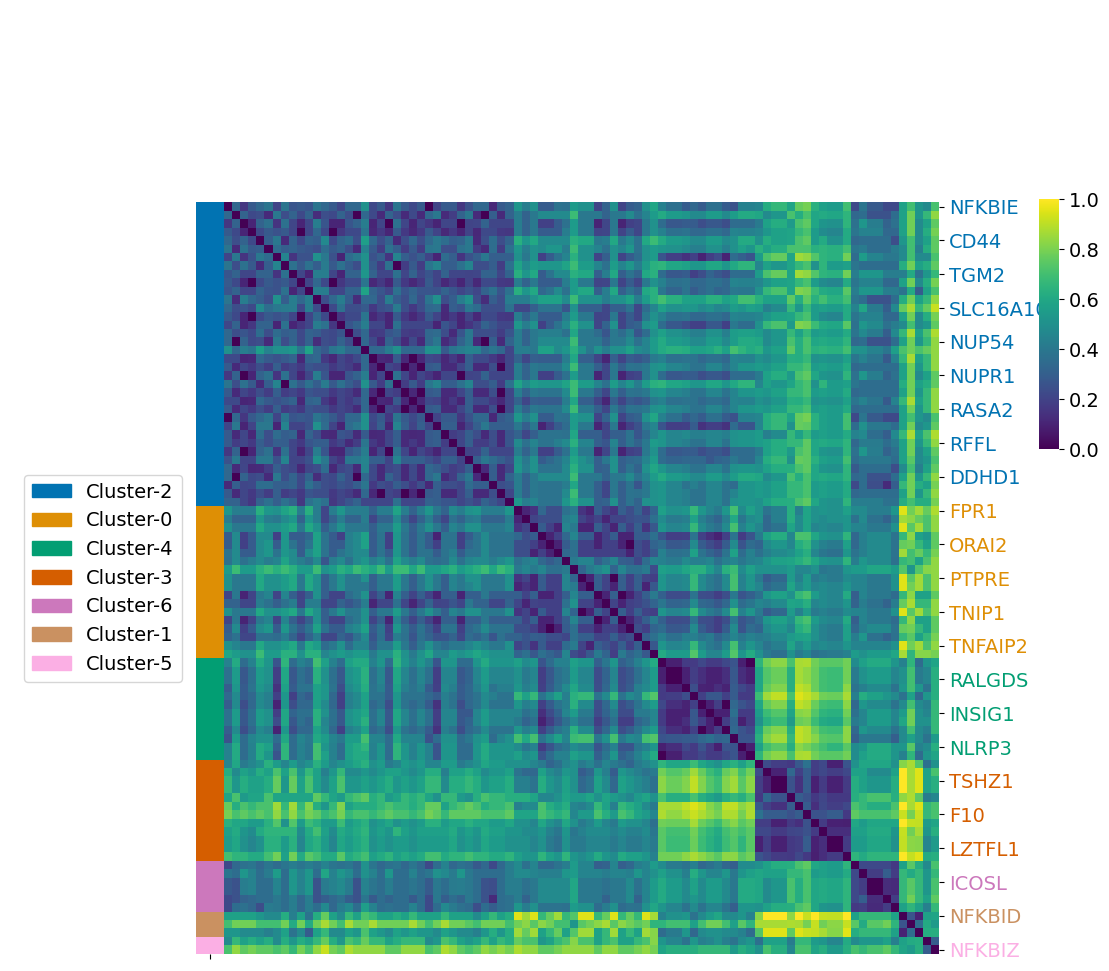

In [92]:
VisualUtils.plot_distmap_with_clusters(aligner)

Print the cluster-specific aggregate (average) alignments for each cluster along with its number of genes

In [93]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IDDDMMMMMMMMIIIIIDDD 18
cluster:  1 IIIDIDIDIDIDDDMMMMMMM 3
cluster:  2 IDDDMMMMMMMMMMIIDI 36
cluster:  3 IDDDMMMMMIMVVVVVIDDDDD 12
cluster:  4 IIIDDDDDDDMMMMMMIIIIID 12
cluster:  5 IIIDIDIDDDDDDMMMMVMVVM 2
cluster:  6 DDMMMMMMMMIIMMMM 6


# Gene-set specific alignments

We can obtain the aggregate (average) alignment for any given gene subset in the aligner 


Average Alignment:  IDDDMMMMMMMIIDIIIIDDD


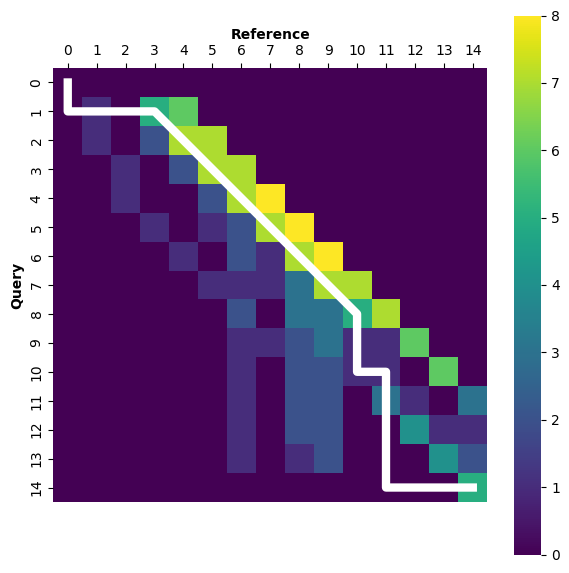

In [12]:
GENE_SUBSET = gene_list[40:60]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET )

We can check aggregate alignment and statistics of a pathway gene set with below provided wrapper function calls to retrieve pathway gene sets

In [13]:
IGS = PathwayAnalyserV2.InterestingGeneSets(MSIGDB_PATH='../MSIGDB/msigdb7.5.1/')
IGS.add_new_set_from_msigdb('hallmark', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', aligner.gene_list, 'EMT')   

mean matched percentage:  51.04 %
mean matched percentage wrt ref:  64.29 %
mean matched percentage wrt query:  67.14 %
Average Alignment:  IDDDMMMMMMMMMMIMI
Z-normalised Interpolated mean trends


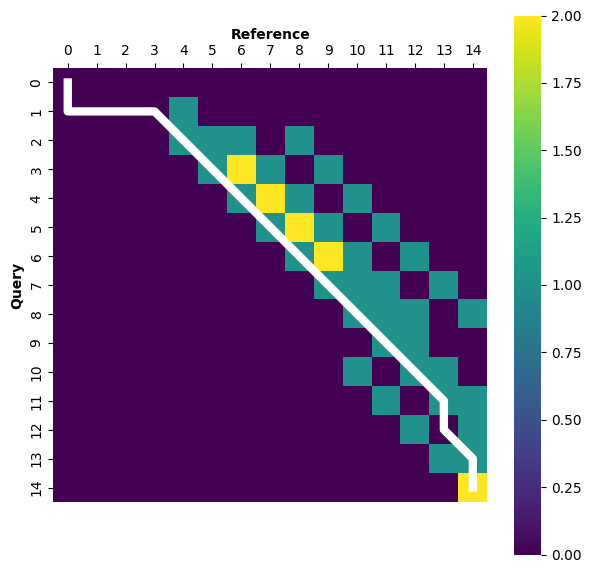

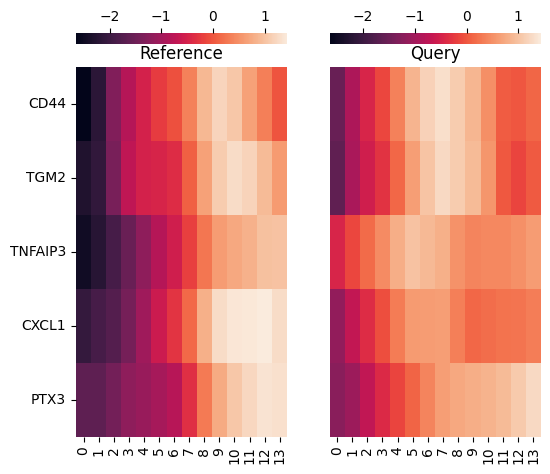

In [17]:
PathwayAnalyserV2.get_pathway_alignment_stat(aligner, IGS.SETS['EMT'], 'EMT', cluster=True, FIGSIZE=(6,6))

# Complementary functions

Show all alignments

In [94]:
aligner.show_ordered_alignments() 

Gene      Alignment
--------  ------------------------
PTAFR     MDDMMMMMMMMMMIIDI
OSBPL3    MDMMMMMMVVVVVVDIDDDDD
RFFL      MDDDMMMMMMMMMMIII
TNFAIP2   MDDMMMMMMMIIDIIIIDDD
SGMS2     DMMMMMMMMMMMMIM
SLC16A10  DMMMMMMMMMMMIIIDD
FPR1      DMMMMMMMMMIIDIIIDDD
FAM20C    DMMMMMMMMDDDMMIIII
CLEC4D    IMMDIDMMMMMMMIIIDDD
TSHZ1     DDMMMMMMMVVVVVVIDDDDD
IL1F9     DDMMMMMMMVVVVVVIDDDDD
PSTPIP2   DDMMMMMMMVVVVVIDIDDDD
RELA      DDMMMMMMMMMMMMII
NUP54     DDMMMMMMMMMMMMII
DDHD1     DDMMMMMMMMMMMMII
NRP2      DDMMMMMMMMMMMIIID
TREM1     DDMMMMMMMMMIIDIIIDD
GRAMD1B   DDMMMMMMMMMIIMMM
TOP1      DDMMMMMMMMIDIIIIIDDD
ICOSL     DDMMMMMMMMIIMMMM
DUSP16    DDMMMMMMMMIIMMMM
PTPRE     DDMMMMMMMMIIIIIIDDDD
LDLR      DDMMMMMMMMIIDIIIIDDD
TNIP1     DDMMMMMMMMIIIIIIDDDD
PLAGL2    DDDMMMMMMMMMMMVVV
ZSWIM4    DDDMMMMMMMMMMMVVV
ZC3H12C   DDDMMMMMMVVVVVVVIDDDDD
AK150559  DDDMMMMMVVVVVVVVIDDDDDD
F10       IDDMMMMVVVVVVVVIDDDDDDDD
FAM108C   DDDMMMMMMMMMMMIII
RBM7      DDDMMMMMMMMMMMIII
RASA2     DDDMMMMMMMMMMMIII
S

30      PTAFR
40     OSBPL3
74       RFFL
80    TNFAIP2
26      SGMS2
       ...   
77     NFKBIA
81       PLK2
88     NFKBIZ
46     NFKBID
63      CCRL2
Name: genes, Length: 89, dtype: object